In [29]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import pickle
import glob
from natsort import natsorted #para ordenar alfabeticamente


In [30]:
folder = '/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/5-Salidas/30agosto_salidas'
Configs = glob.glob(folder+'/*/TrainConf.pkl')
Configs = natsorted(Configs)

#---
Stats = glob.glob(folder+'/*/ModelStats.pkl')
Stats = natsorted(Stats)

#Codigo entero

#Genero una lista con todos los hiperparametros de interes para estudiar la sensibilida
hiperparameters1 = ['BatchSize','LearningRate','WeightDecay']
hiperparameters2 = ['KernelSize','Pool','Bias','OutActivation','Channels']
hiperparameters3 = hiperparameters1 + hiperparameters2

#Genero un diccionario donde almaceno los hiperparametros de cada experimento
hip_exp = {}

#Itero a lo largo de las configuraciones
for conf in Configs:
    with open(conf,'rb') as file:
        data = pickle.load(file)

        #Numero experimento
        num = 'ExpNumber' + str(data['ExpNumber'])
        #Extraemos los hiperparametros de cada experimento y lo almacenamos
        lista1 = list(map(data.get,hiperparameters1))
        lista2 = list(map(data['ModelConf'].get,hiperparameters2)) #kernelsize estan dentro de modelConf

        lista3 = lista1 + lista2

        hip_exp[num] = lista3

#Transformamos el diccionario a un dataframe
df = pd.DataFrame(hip_exp)
df = df.T
df.columns = hiperparameters3

df['Bias'] = df['Bias'].astype(int)

#Genero un dataframe que tiene en cada columna los canales 
adicional = pd.DataFrame(df['Channels'].tolist())
adicional.columns = [f'Channel_{i+1}' for i in range(adicional.shape[1])]
adicional.index = df.index

df_hiper = pd.concat([df, adicional], axis=1).drop(columns=['Channels'])

rmse = {}
for exp,stat in zip(df.index,Stats):
    with open(stat,'rb') as file:
        data = pickle.load(file)
        rmse[exp] = data['RMSE']

df_rmse = pd.DataFrame(rmse)

df_rmse = df_rmse.tail(1) #el ultimo valor de rmse de cada exp

In [31]:
parametro_interes = hiperparameters3

#Borra la columna del hiperparametro de interes y se queda con las filas duplicadas
#o sea obtengo los experimentos donde solo vairo el learning rate

lista_df_plots = []
n_exp = []
for my_interes in parametro_interes:
    print(my_interes)

    if my_interes != "Channels":
        
        #Filtra de manera de que queden solo filas , pero no BORRA la columna con el hiperparametro
        df_final = df_hiper[df_hiper.drop(columns=[my_interes]).duplicated(keep=False)]

        #Me quedo con los rmse de los experimentos donde solo vario mi hiperparametro
        df_plot = df_rmse[df_final.index.values]
        
        #Me guardo los experimentos de cada hiperparametro
        n_exp.append(df_plot.columns)

        #Cambio nombre
        df_plot.columns = df_final[my_interes].values

        lista_df_plots.append(df_plot)

    #En el caso que sea channels
    else:

        #Borro todas las columnas que contengan la palabra channel de header
        df_final = df_hiper[df_hiper[df_hiper.columns.drop(list(df_hiper.filter(regex='Channel')))].duplicated(keep=False)]
        
        #Me quedo con los rmse de los experimentos donde solo vario mi hiperparametro
        df_plot = df_rmse[df_final.index.values]

        #Me guardo los experimentos de cada hiperparametro
        n_exp.append(df_plot.columns)

        #Modificamos el dataframe 
        df_final['Canales'] = df_final[df_final.filter(regex='Channel').columns.values].astype(str).agg(', '.join, axis=1)

        #Cambio nombre
        df_plot.columns = df_final['Canales'].values

        lista_df_plots.append(df_plot)
        print('a')


BatchSize
LearningRate
WeightDecay
KernelSize
Pool
Bias
OutActivation
Channels
a


/tmp/ipykernel_1253232/2579342942.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Canales'] = df_final[df_final.filter(regex='Channel').columns.values].astype(str).agg(', '.join, axis=1)


In [32]:
parametro_interes

['BatchSize',
 'LearningRate',
 'WeightDecay',
 'KernelSize',
 'Pool',
 'Bias',
 'OutActivation',
 'Channels']

#este andaba

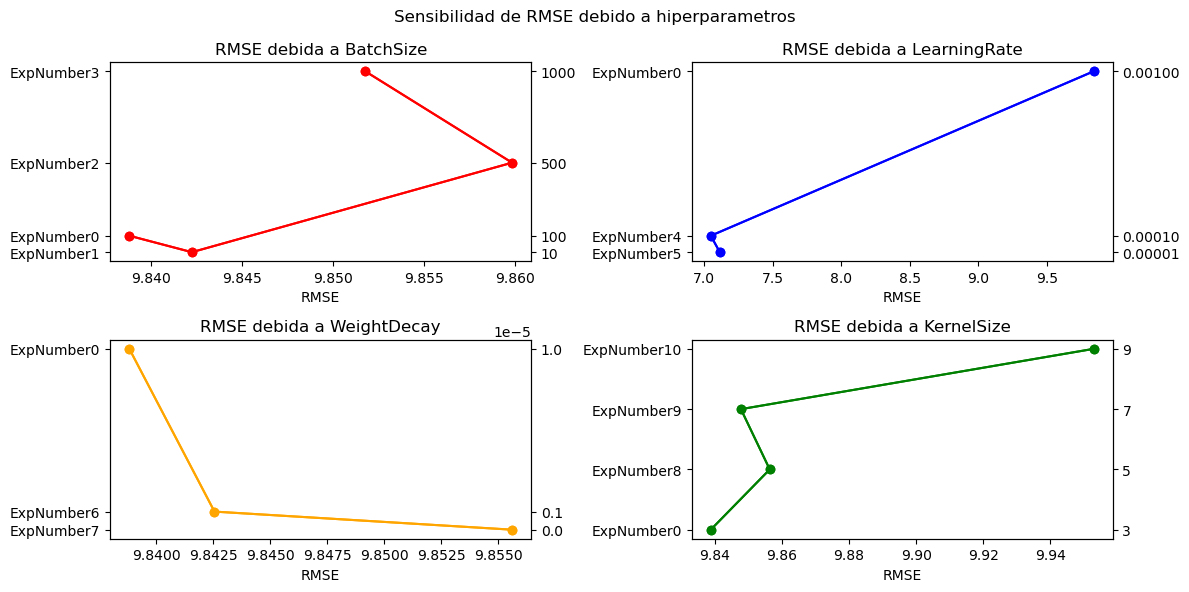

In [212]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
plt.suptitle('Sensibilidad de RMSE debido a hiperparametros')

# ---------------------Gráfico 1-------
axs[0, 0].set_title(f"RMSE debida a {parametro_interes[0]}")
axs[0, 0].set_xlabel('RMSE')
axs[0, 0].plot(lista_df_plots[0].values[0], lista_df_plots[0].columns, color="red", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[0, 0].set_yticks(list(lista_df_plots[0].columns))

#Le cambia el nombre para que diga los experimentos
axs[0,0].set_yticklabels(n_exp[0])

#Agrega un nuevo eje con el valor de los hiperparametros
ax2 = axs[0, 0].twinx()
ax2.plot(lista_df_plots[0].values[0], lista_df_plots[0].columns, color="red", marker='o')
ax2.set_yticks(list(lista_df_plots[0].columns))

#-------------------------GRAFICO 2

axs[0, 1].set_title(f"RMSE debida a {parametro_interes[1]}")
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].plot(lista_df_plots[1].values[0], lista_df_plots[1].columns, color="blue", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[0, 1].set_yticks(list(lista_df_plots[1].columns))

#Le cambia el nombre para que diga los experimentos
axs[0,1].set_yticklabels(n_exp[1])

#Agrega un nuevo eje con el valor de los hiperparametros
ax3 = axs[0, 1].twinx()
ax3.plot(lista_df_plots[1].values[0], lista_df_plots[1].columns, color="blue", marker='o')
ax3.set_yticks(list(lista_df_plots[1].columns))

#-------------------------GRAFICO 3

axs[1, 0].set_title(f"RMSE debida a {parametro_interes[2]}")
axs[1, 0].set_xlabel('RMSE')
axs[1, 0].plot(lista_df_plots[2].values[0], lista_df_plots[2].columns, color="orange", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[1, 0].set_yticks(list(lista_df_plots[2].columns))

#Le cambia el nombre para que diga los experimentos
axs[1,0].set_yticklabels(n_exp[2])

#Agrega un nuevo eje con el valor de los hiperparametros
ax4 = axs[1, 0].twinx()
ax4.plot(lista_df_plots[2].values[0], lista_df_plots[2].columns, color="orange", marker='o')
ax4.set_yticks(list(lista_df_plots[2].columns))

#-------------------------GRAFICO 4

axs[1, 1].set_title(f"RMSE debida a {parametro_interes[3]}")
axs[1, 1].set_xlabel('RMSE')
axs[1, 1].plot(lista_df_plots[3].values[0], lista_df_plots[3].columns, color="green", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[1, 1].set_yticks(list(lista_df_plots[3].columns))

#Le cambia el nombre para que diga los experimentos
axs[1,1].set_yticklabels(n_exp[3])

#Agrega un nuevo eje con el valor de los hiperparametros
ax5 = axs[1, 1].twinx()
ax5.plot(lista_df_plots[3].values[0], lista_df_plots[3].columns, color="green", marker='o')
ax5.set_yticks(list(lista_df_plots[3].columns))



plt.tight_layout()


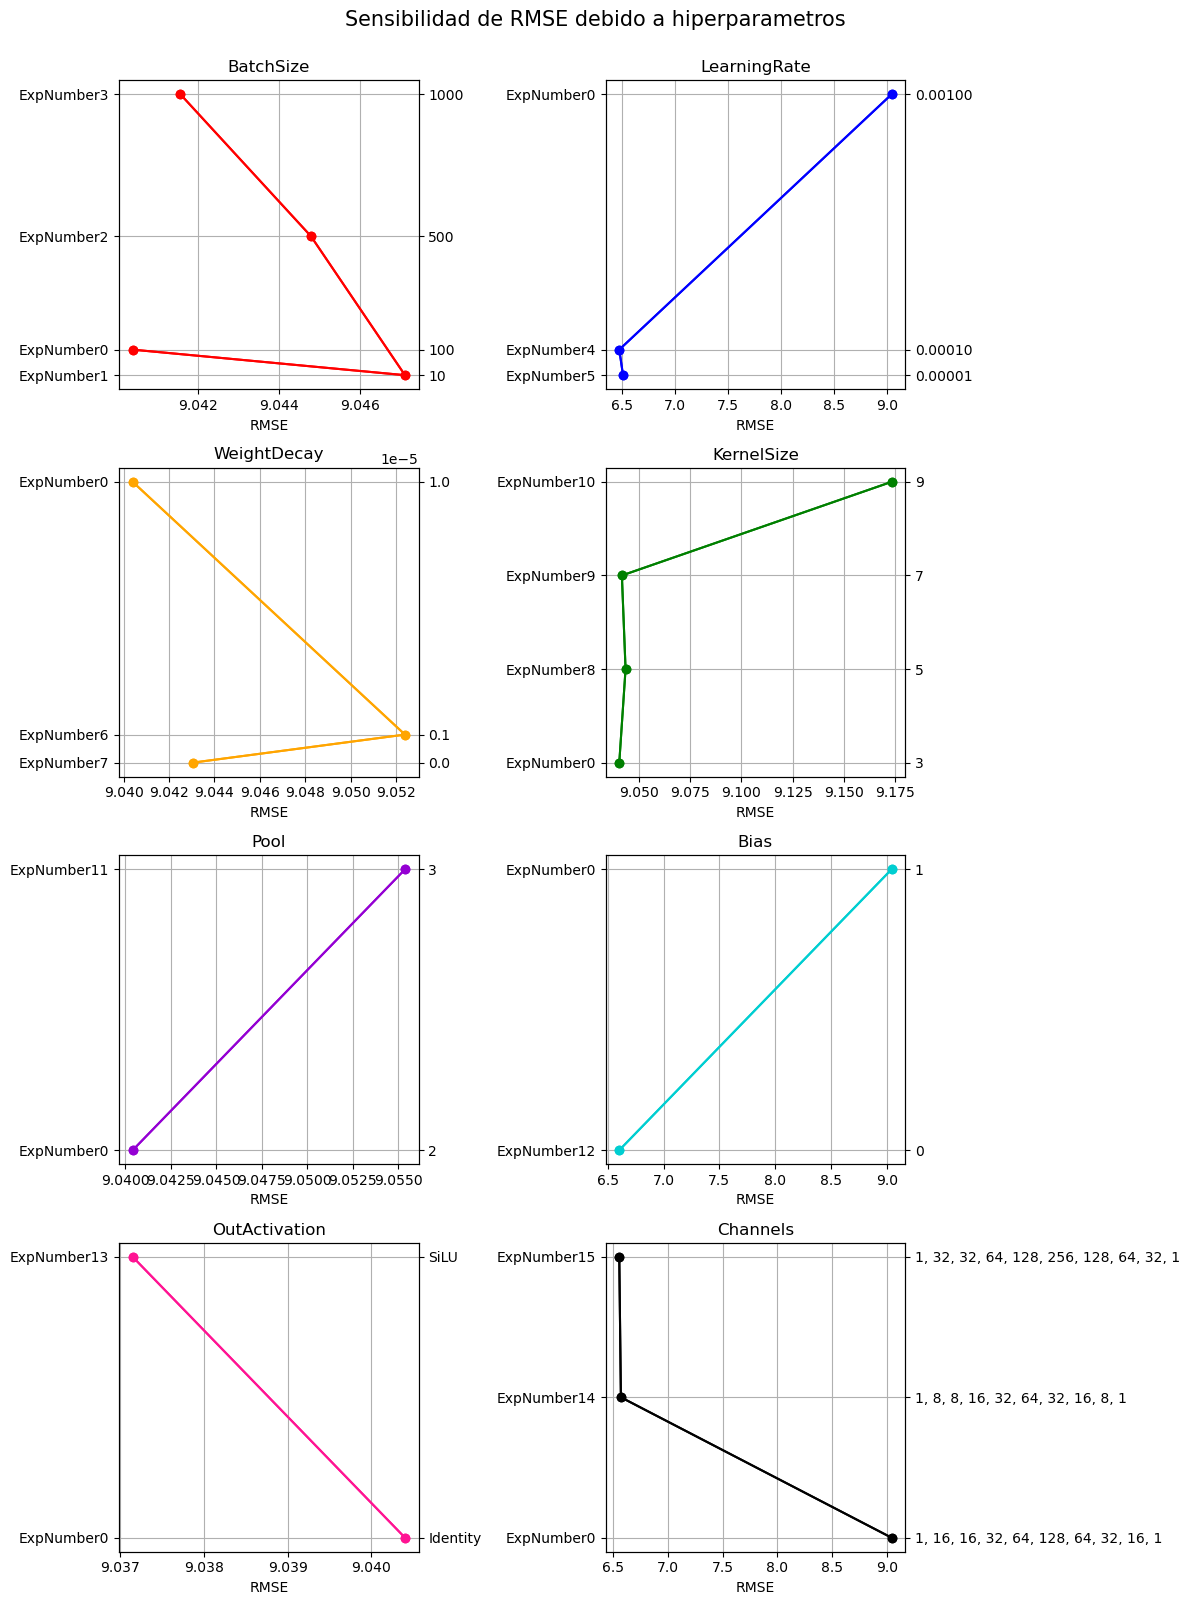

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(12, 16))
plt.suptitle('Sensibilidad de RMSE debido a hiperparametros',fontsize= 15,y=1)

# ---------------------Gráfico 1-------
axs[0, 0].set_title(f"{parametro_interes[0]}")
axs[0, 0].set_xlabel('RMSE')
axs[0, 0].plot(lista_df_plots[0].values[0], lista_df_plots[0].columns, color="red", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[0, 0].set_yticks(list(lista_df_plots[0].columns))

#Le cambia el nombre para que diga los experimentos
axs[0,0].set_yticklabels(n_exp[0])

#Agrega un nuevo eje con el valor de los hiperparametros
ax2 = axs[0, 0].twinx()
ax2.plot(lista_df_plots[0].values[0], lista_df_plots[0].columns, color="red", marker='o')
ax2.set_yticks(list(lista_df_plots[0].columns))
axs[0,0].grid()

#-------------------------GRAFICO 2

axs[0, 1].set_title(f"{parametro_interes[1]}")
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].plot(lista_df_plots[1].values[0], lista_df_plots[1].columns, color="blue", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[0, 1].set_yticks(list(lista_df_plots[1].columns))

#Le cambia el nombre para que diga los experimentos
axs[0,1].set_yticklabels(n_exp[1])

#Agrega un nuevo eje con el valor de los hiperparametros
ax3 = axs[0, 1].twinx()
ax3.plot(lista_df_plots[1].values[0], lista_df_plots[1].columns, color="blue", marker='o')
ax3.set_yticks(list(lista_df_plots[1].columns))
axs[0,1].grid()



#-------------------------GRAFICO 3

axs[1, 0].set_title(f"{parametro_interes[2]}")
axs[1, 0].set_xlabel('RMSE')
axs[1, 0].plot(lista_df_plots[2].values[0], lista_df_plots[2].columns, color="orange", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[1, 0].set_yticks(list(lista_df_plots[2].columns))

#Le cambia el nombre para que diga los experimentos
axs[1,0].set_yticklabels(n_exp[2])

#Agrega un nuevo eje con el valor de los hiperparametros
ax4 = axs[1, 0].twinx()
ax4.plot(lista_df_plots[2].values[0], lista_df_plots[2].columns, color="orange", marker='o')
ax4.set_yticks(list(lista_df_plots[2].columns))
axs[1,0].grid()


#-------------------------GRAFICO 4

axs[1, 1].set_title(f"{parametro_interes[3]}")
axs[1, 1].set_xlabel('RMSE')
axs[1, 1].plot(lista_df_plots[3].values[0], lista_df_plots[3].columns, color="green", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[1, 1].set_yticks(list(lista_df_plots[3].columns))

#Le cambia el nombre para que diga los experimentos
axs[1,1].set_yticklabels(n_exp[3])

#Agrega un nuevo eje con el valor de los hiperparametros
ax5 = axs[1, 1].twinx()
ax5.plot(lista_df_plots[3].values[0], lista_df_plots[3].columns, color="green", marker='o')
ax5.set_yticks(list(lista_df_plots[3].columns))
axs[1,1].grid()


#-------------------------GRAFICO 5

axs[2, 0].set_title(f"{parametro_interes[4]}")
axs[2, 0].set_xlabel('RMSE')
axs[2, 0].plot(lista_df_plots[4].values[0], lista_df_plots[4].columns, color="darkviolet", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[2,0].set_yticks(list(lista_df_plots[4].columns))

#Le cambia el nombre para que diga los experimentos
axs[2,0].set_yticklabels(n_exp[4])

#Agrega un nuevo eje con el valor de los hiperparametros
ax6 = axs[2,0].twinx()
ax6.plot(lista_df_plots[4].values[0], lista_df_plots[4].columns, color="darkviolet", marker='o')
ax6.set_yticks(list(lista_df_plots[4].columns))
axs[2,0].grid()



#-------------------------GRAFICO 6

axs[2, 1].set_title(f"{parametro_interes[5]}")
axs[2, 1].set_xlabel('RMSE')
axs[2, 1].plot(lista_df_plots[5].values[0], lista_df_plots[5].columns, color="darkturquoise", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[2,1].set_yticks(list(lista_df_plots[5].columns))

#Le cambia el nombre para que diga los experimentos
axs[2,1].set_yticklabels(n_exp[5])

#Agrega un nuevo eje con el valor de los hiperparametros
ax7 = axs[2,1].twinx()
ax7.plot(lista_df_plots[5].values[0], lista_df_plots[5].columns, color="darkturquoise", marker='o')
ax7.set_yticks(list(lista_df_plots[5].columns))
axs[2,1].grid()


#-------------------------GRAFICO 7

axs[3, 0].set_title(f"{parametro_interes[6]}")
axs[3, 0].set_xlabel('RMSE')
axs[3, 0].plot(lista_df_plots[6].values[0], lista_df_plots[6].columns, color="deeppink", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[3,0].set_yticks(list(lista_df_plots[6].columns))

#Le cambia el nombre para que diga los experimentos
axs[3,0].set_yticklabels(n_exp[6])

#Agrega un nuevo eje con el valor de los hiperparametros
ax7 = axs[3,0].twinx()
ax7.plot(lista_df_plots[6].values[0], lista_df_plots[6].columns, color="deeppink", marker='o')
ax7.set_yticks(list(lista_df_plots[6].columns))
axs[3,0].grid()


#-------------------------GRAFICO 8

axs[3, 1].set_title(f"{parametro_interes[7]}")
axs[3, 1].set_xlabel('RMSE')
axs[3, 1].plot(lista_df_plots[7].values[0], lista_df_plots[7].columns, color="black", marker='o')
# Modifica el eje para que solo muestre los quetiene
axs[3,1].set_yticks(list(lista_df_plots[7].columns))

#Le cambia el nombre para que diga los experimentos
axs[3,1].set_yticklabels(n_exp[7])

#Agrega un nuevo eje con el valor de los hiperparametros
ax8 = axs[3,1].twinx()
ax8.plot(lista_df_plots[7].values[0], lista_df_plots[7].columns, color="black", marker='o')
ax8.set_yticks(list(lista_df_plots[7].columns))
axs[3,1].grid()
###############################3

plt.tight_layout()
plt.savefig('hiperparametersfig.png',dpi=300)

In [45]:
df_rmse.columns

Index(['ExpNumber0', 'ExpNumber1', 'ExpNumber2', 'ExpNumber3', 'ExpNumber4',
       'ExpNumber5', 'ExpNumber6', 'ExpNumber7', 'ExpNumber8', 'ExpNumber9',
       'ExpNumber10', 'ExpNumber11', 'ExpNumber12', 'ExpNumber13',
       'ExpNumber14', 'ExpNumber15'],
      dtype='object')

In [ ]:
df_r

In [48]:
df_rmse_transpuesta = df_rmse.T 
df_rmse_transpuesta.columns =['RMSE']
df_global = pd.concat([df,df_rmse_transpuesta],axis=1)
df_global

RangeIndex(start=39, stop=40, step=1)

In [51]:
df_rmse_transpuesta.columns = ['RMSE']

In [79]:
df_global = pd.concat([df,df_rmse_transpuesta],axis=1)


In [80]:
xx = df_global.sort_values(by='RMSE')
xx

,BatchSize,LearningRate,WeightDecay,KernelSize,Pool,Bias,OutActivation,Channels,RMSE
ExpNumber4,100,0.0001,0.00001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",6.472679
ExpNumber5,100,0.00001,0.00001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",6.508028
ExpNumber15,100,0.001,0.00001,3,2,1,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",6.557135
ExpNumber14,100,0.001,0.00001,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",6.571888
ExpNumber12,100,0.001,0.00001,3,2,0,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",6.604232
ExpNumber13,100,0.001,0.00001,3,2,1,SiLU,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.037153
ExpNumber0,100,0.001,0.00001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.040400
ExpNumber3,1000,0.001,0.00001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.041578
ExpNumber9,100,0.001,0.00001,7,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.041672
ExpNumber7,100,0.001,0.0,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.043033


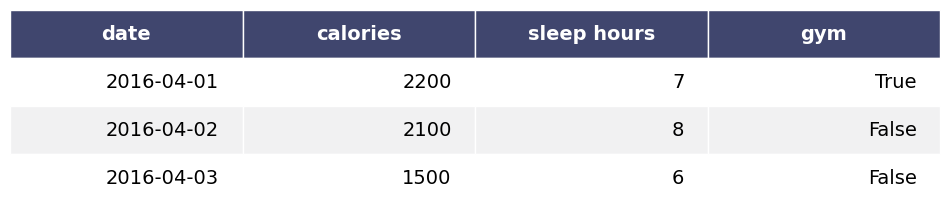

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six

# Crear el DataFrame de ejemplo
df = pd.DataFrame()
df['date'] = ['2016-04-01', '2016-04-02', '2016-04-03']
df['calories'] = [2200, 2100, 1500]
df['sleep hours'] = [7, 8, 6]
df['gym'] = [True, False, False]

# Función para renderizar la tabla
def render_mpl_table(data, col_width=10.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    # Si no hay un eje proporcionado, creamos uno nuevo con el tamaño adecuado
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')  # Quitamos los ejes

    # Creamos la tabla
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    # Ajustamos la fuente
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    # Estilo de las celdas
    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)  # Color del borde de las celdas
        if k[0] == 0 or k[1] < header_columns:  # Cabecera
            cell.set_text_props(weight='bold', color='w')  # Texto en negrita y blanco
            cell.set_facecolor(header_color)  # Color de fondo de la cabecera
        else:  # Filas de datos
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])  # Alternamos colores de fila
    return ax

# Renderizamos la tabla
render_mpl_table(df, header_columns=0, col_width=3.0)

# Guardamos como imagen
plt.savefig("table_image.png", bbox_inches='tight', dpi=300)

# Mostramos la imagen generada
plt.show()


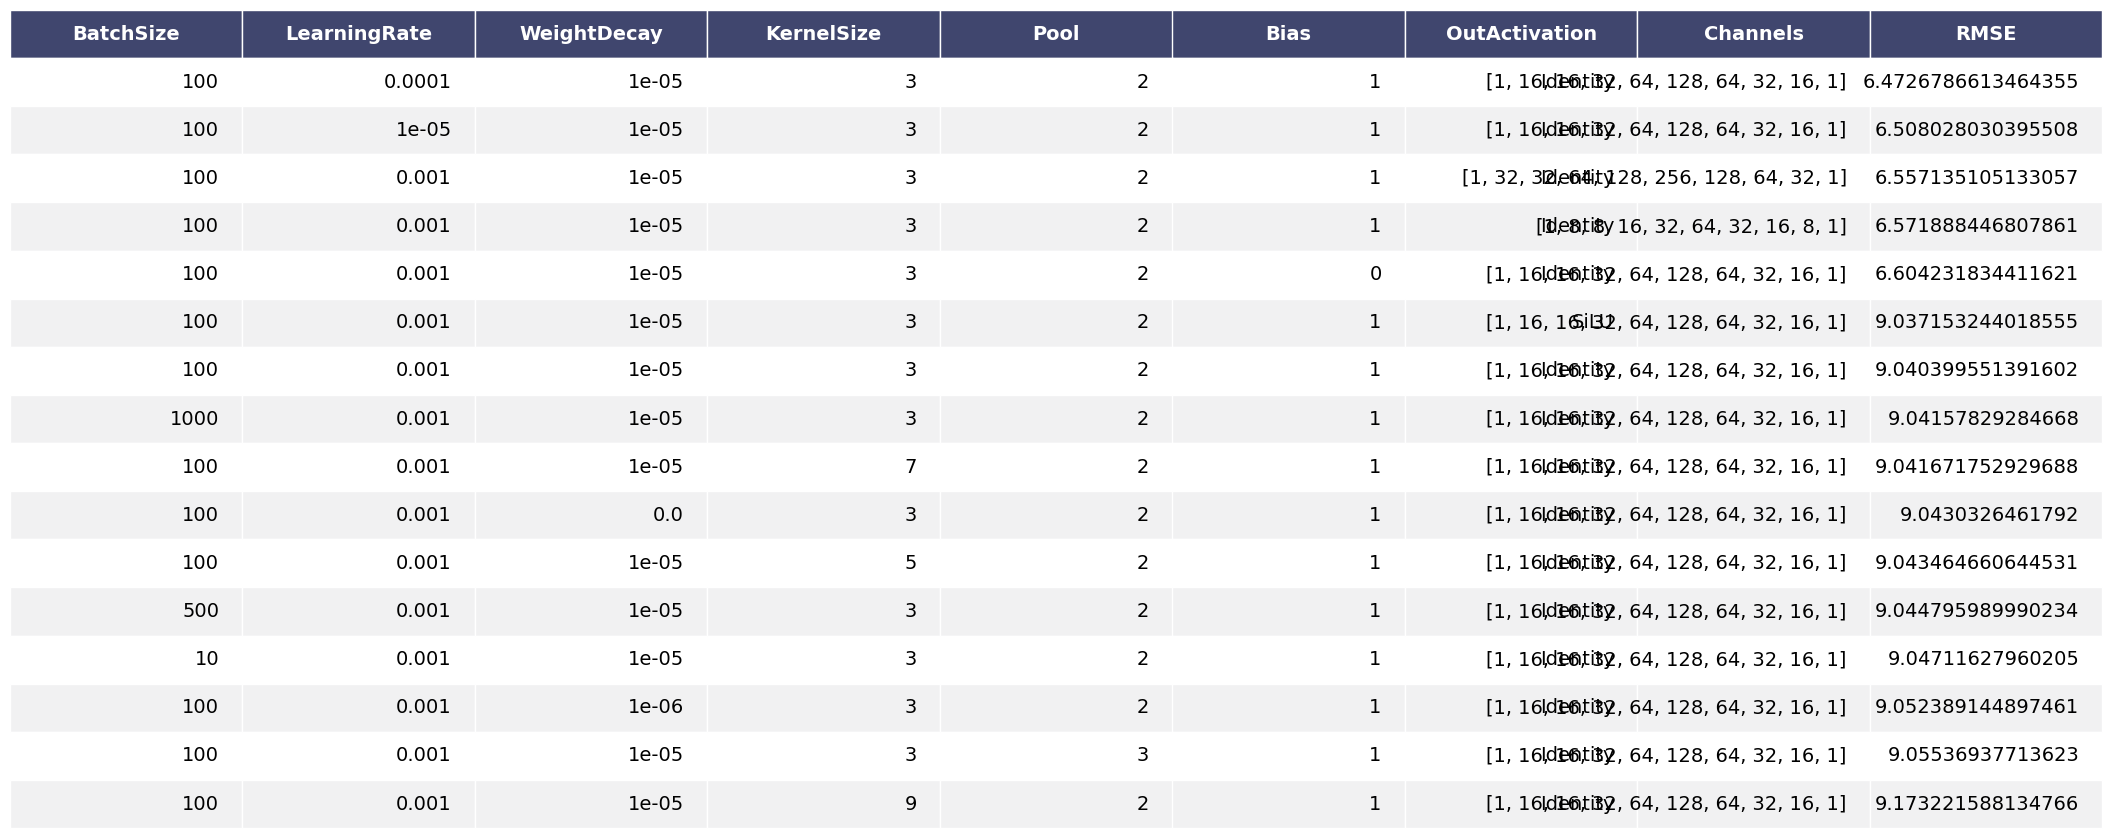

In [93]:
# Renderizamos la tabla
render_mpl_table(xx, header_columns=0, col_width=3.0)

# Guardamos como imagen
plt.savefig("table_image.png", bbox_inches='tight', dpi=300)

# Mostramos la imagen generada
plt.show()


In [94]:
pip install matplotlib dataframe_image pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 3.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 51.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.8/446.8 kB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 30.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [97]:
xx.to_csv('archivo.csv')

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi

# Crear un DataFrame de ejemplo
data = {'Columna1': [10, 20, 30],
        'Columna2': [40, 50, 60],
        'Columna3': [70, 80, 90]}
df = pd.DataFrame(data)

# Guardar el DataFrame como imagen
dfi.export(df, 'dataframe_image.png')


OSError: Chrome executable not able to be found on your machine

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi

# Crear un DataFrame de ejemplo
data = {'Columna1': [10, 20, 30],
        'Columna2': [40, 50, 60],
        'Columna3': [70, 80, 90]}
df = pd.DataFrame(data)

# Guardar el DataFrame como imagen
dfi.export(df, 'dataframe_image.png')


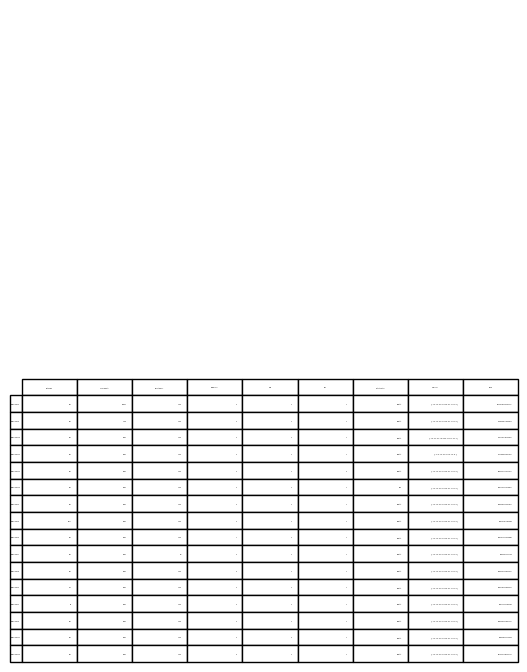

In [91]:

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
# EDIT: see deprecation warnings below

ax = plt.subplot(111, frame_on=True) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, xx)  # where df is your data frame

plt.savefig('mytable.png')

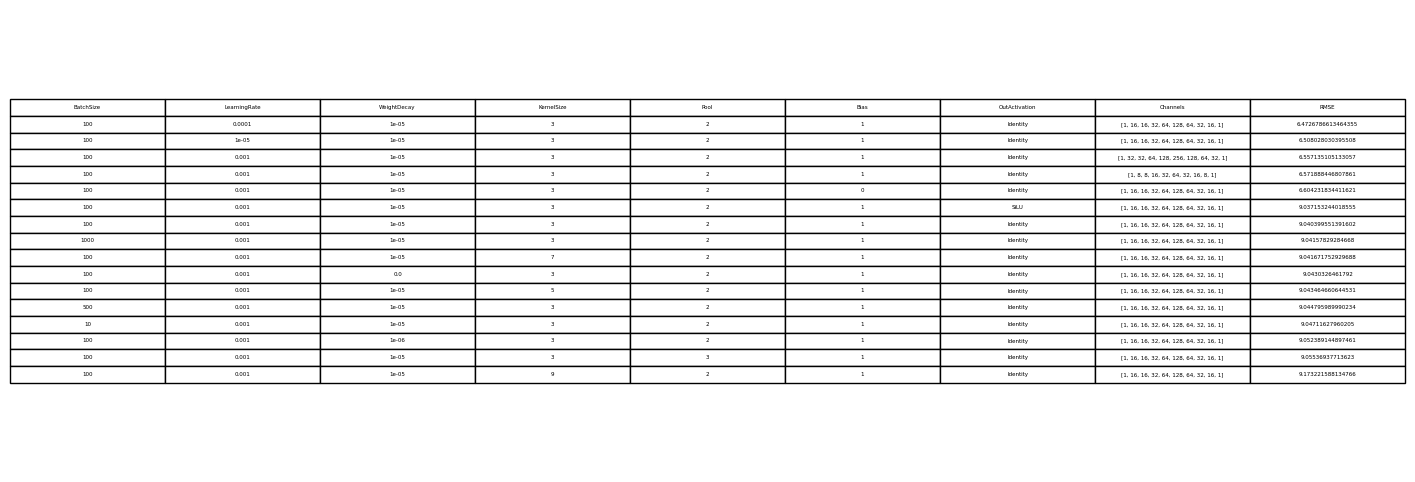

In [88]:

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(18, 6))  # Ajustar tamaño de la imagen según el contenido

# Ocultar los ejes
ax.axis('tight')
ax.axis('off')

# Crear la tabla en el gráfico
table = ax.table(cellText=xx.values, colLabels=xx.columns, cellLoc='center', loc='center')

# Ajustar el tamaño de las celdas si es necesario
table.auto_set_font_size(True)
#table.set_fontsize(12)
#table.scale(1.1,2)  # Ajustar las proporciones horizontal y verticalmente

# Guardar la tabla como imagen PNG
plt.savefig("experiment_table.png", bbox_inches='tight', dpi=300)

# Mostrar la tabla (opcional)
plt.show()


In [73]:
from tabulate import tabulate


In [78]:
xx

,BatchSize,LearningRate,WeightDecay,KernelSize,Pool,Bias,OutActivation,Channels,RMSE
index,,,,,,,,,
ExpNumber4,100,0.0001,0.00001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",6.472679
ExpNumber5,100,0.00001,0.00001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",6.508028
ExpNumber15,100,0.001,0.00001,3,2,1,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",6.557135
ExpNumber14,100,0.001,0.00001,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",6.571888
ExpNumber12,100,0.001,0.00001,3,2,0,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",6.604232
ExpNumber13,100,0.001,0.00001,3,2,1,SiLU,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.037153
ExpNumber0,100,0.001,0.00001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.040400
ExpNumber3,1000,0.001,0.00001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.041578
ExpNumber9,100,0.001,0.00001,7,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.041672


In [74]:
# Convertir el DataFrame a lista de listas y obtener los encabezados
table_data = xx.values.tolist()
headers = xx.columns.tolist()

# Crear la tabla con formato LaTeX usando tabulate
table_latex = tabulate(table_data, headers, tablefmt="latex")

# Mostrar la tabla en formato LaTeX
print(table_latex)

\begin{tabular}{rrrrrrllr}
\hline
   BatchSize &   LearningRate &   WeightDecay &   KernelSize &   Pool &   Bias & OutActivation   & Channels                                  &    RMSE \\
\hline
         100 &         0.0001 &         1e-05 &            3 &      2 &      1 & Identity        & [1, 16, 16, 32, 64, 128, 64, 32, 16, 1]   & 6.47268 \\
         100 &         1e-05  &         1e-05 &            3 &      2 &      1 & Identity        & [1, 16, 16, 32, 64, 128, 64, 32, 16, 1]   & 6.50803 \\
         100 &         0.001  &         1e-05 &            3 &      2 &      1 & Identity        & [1, 32, 32, 64, 128, 256, 128, 64, 32, 1] & 6.55714 \\
         100 &         0.001  &         1e-05 &            3 &      2 &      1 & Identity        & [1, 8, 8, 16, 32, 64, 32, 16, 8, 1]       & 6.57189 \\
         100 &         0.001  &         1e-05 &            3 &      2 &      0 & Identity        & [1, 16, 16, 32, 64, 128, 64, 32, 16, 1]   & 6.60423 \\
         100 &         0.001  &    

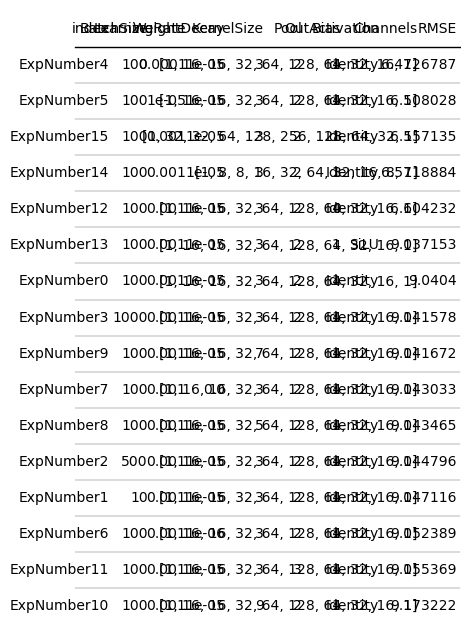

In [70]:
fig, ax = plt.subplots(figsize=(5, 8))
tab = Table(xx)
plt.show()

In [1]:
from analisis_sensibilidad import plotear_sensibilidad_tabla



In [102]:
plot_hiperparameters_and_table(plot_hiperparameters_and_table)

TypeError: plot_hiperparameters_and_table() missing 1 required positional argument: 'outpath'

In [105]:
print('a')

a


/datosmunin2/fernando.huaranca/Thesis_Neuronal_Network/work/4-Experimentos/analisis_sensibilidad.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Canales'] = df_final[df_final.filter(regex='Channel').columns.values].astype(str).agg(', '.join, axis=1)


Creando tabla...
proceso finalizado!


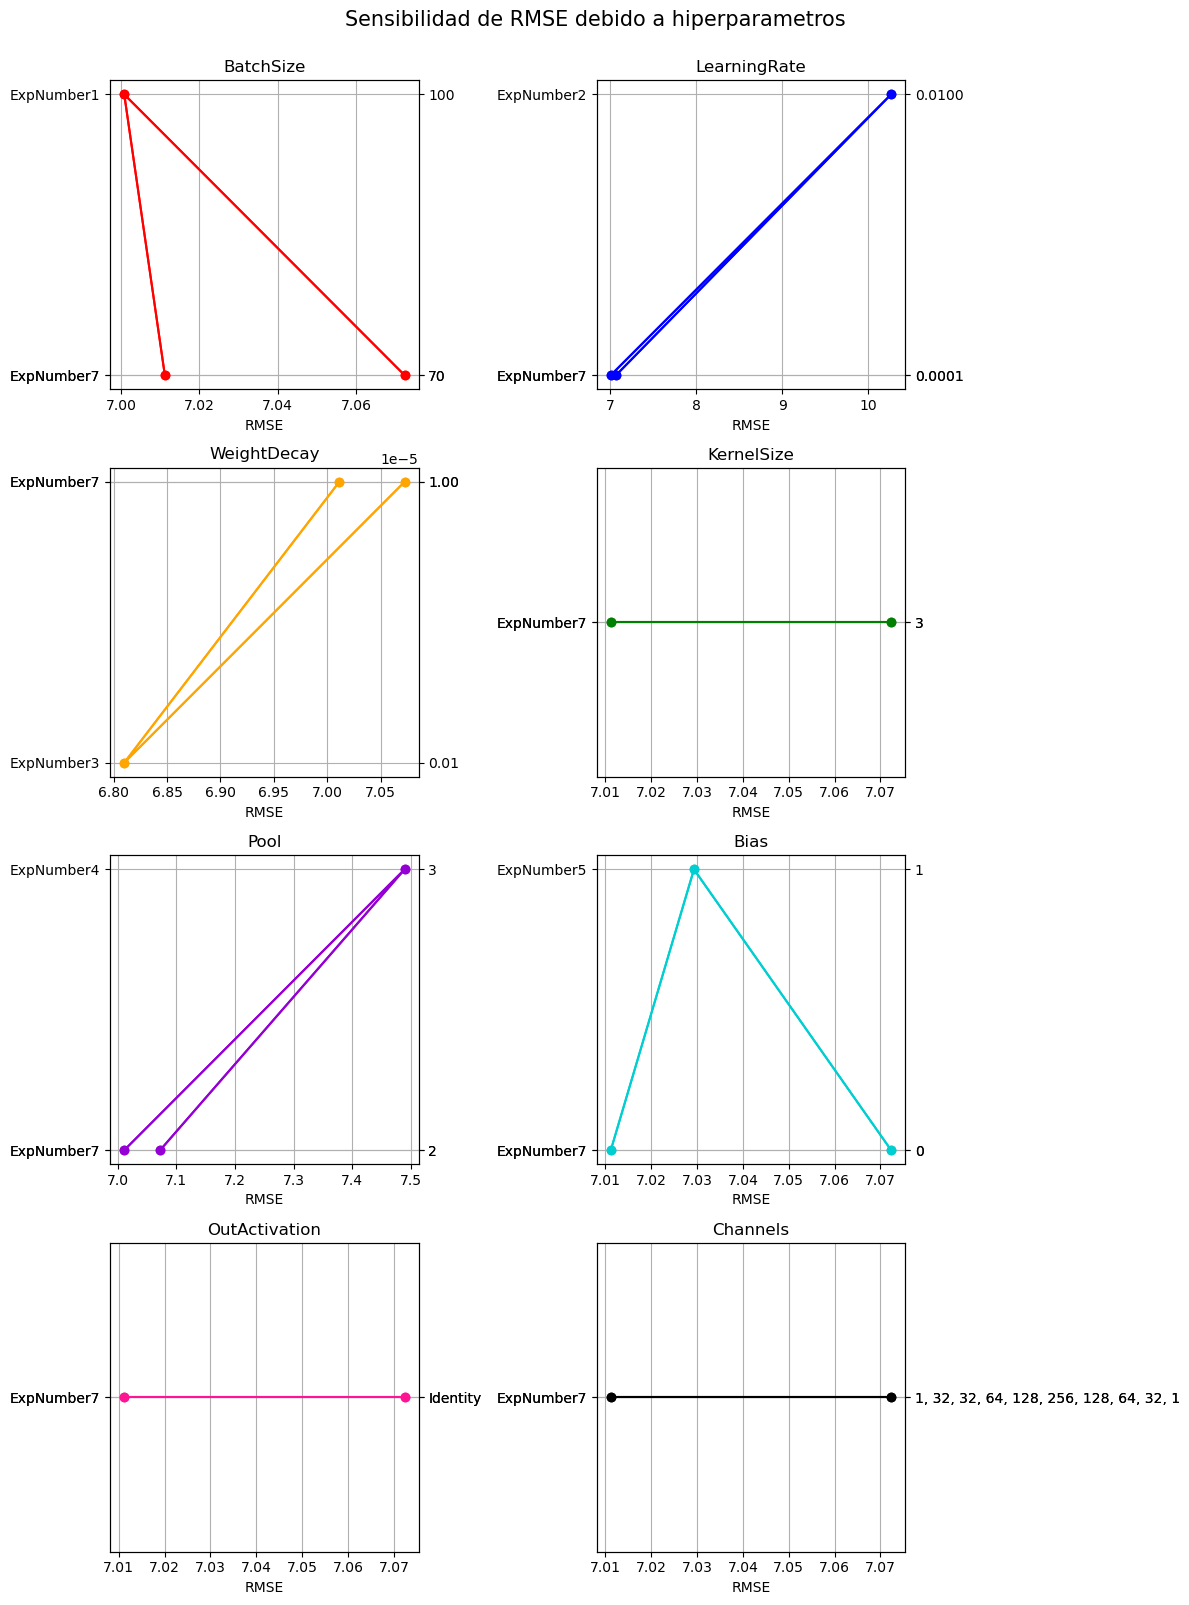

In [2]:
plotear_sensibilidad_tabla('/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/5-Salidas/23sep_salidas','/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/4-Experimentos')

BatchSize
LearningRate
WeightDecay
KernelSize
Pool
Bias
OutActivation
Channels


/datosmunin2/fernando.huaranca/Thesis_Neuronal_Network/work/4-Experimentos/analisis_sensibilidad.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


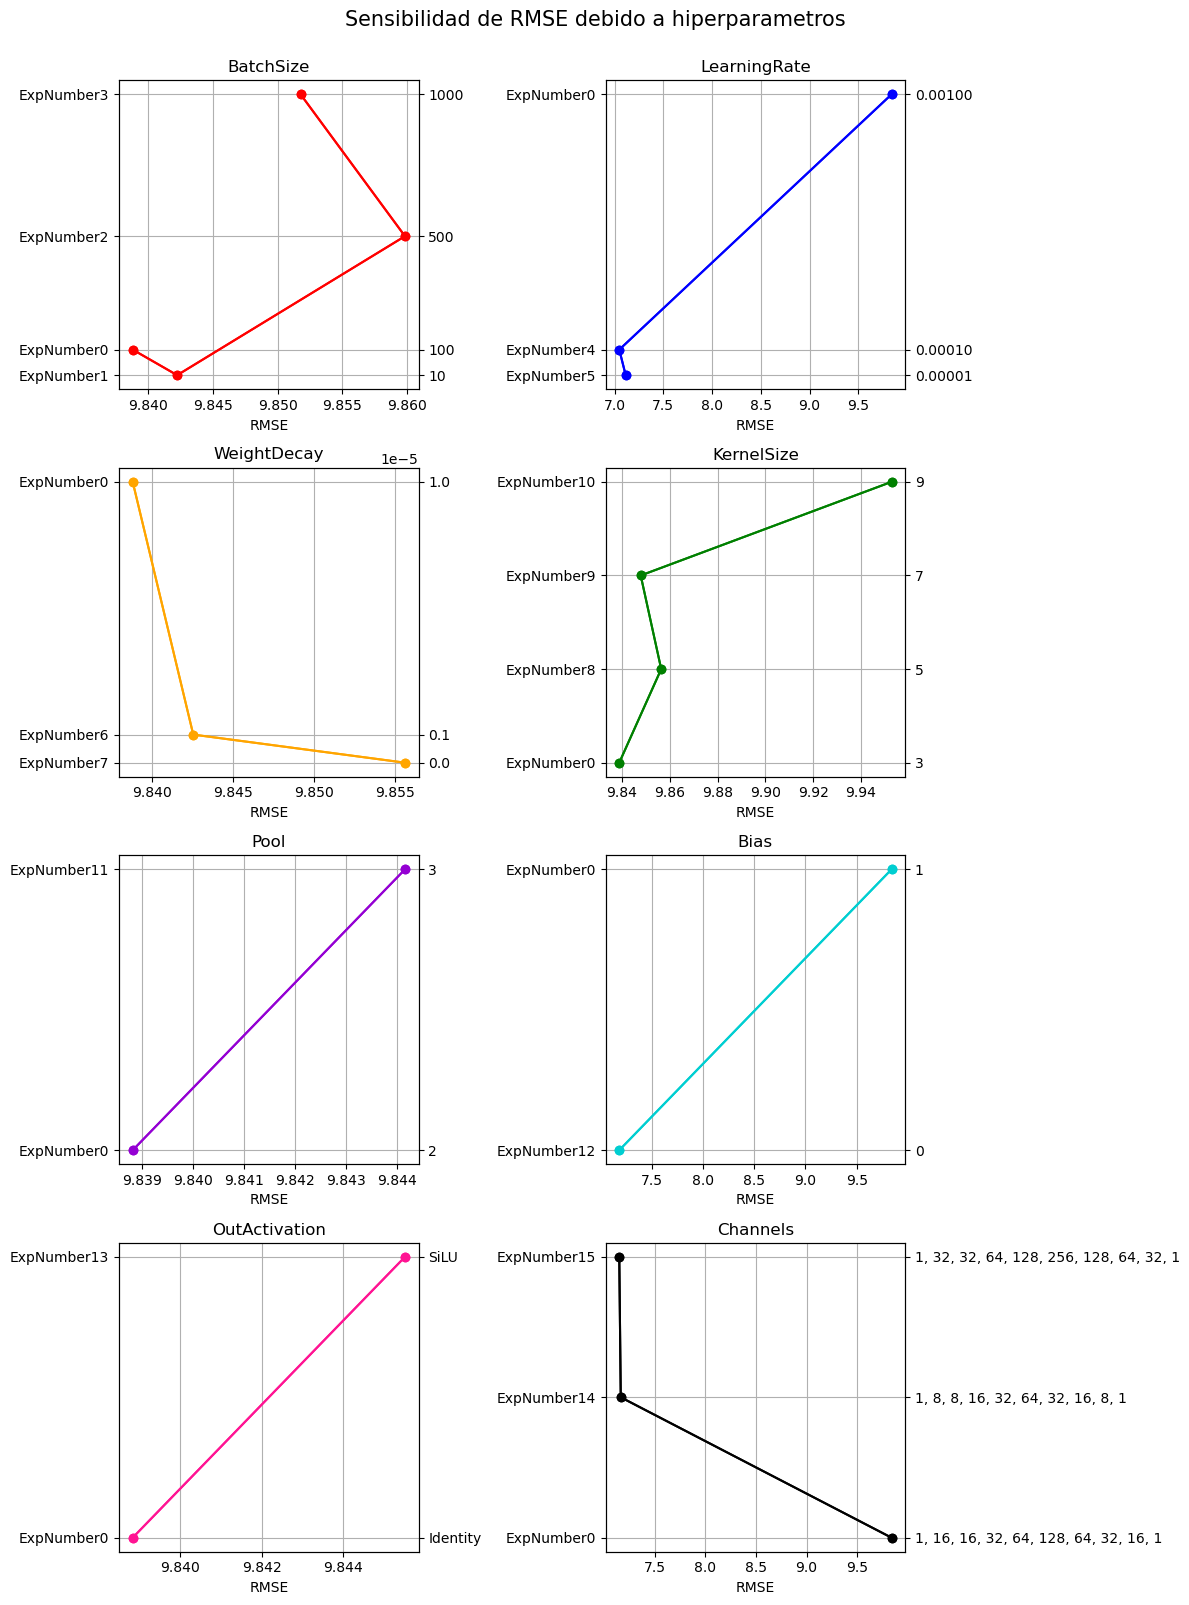

In [110]:
plot_hiperparameters_and_table('/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/5-Salidas/31agosto_salidas','/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/5-Salidas/31agosto_salidas')

In [3]:
import pandas as pd

In [8]:
df = pd.read_csv('/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/5-Salidas/31agosto_salidas/tabla_hiperparametros.csv')

In [7]:
df#.sort_values(by='RMSE')

,Unnamed: 0,BatchSize,LearningRate,WeightDecay,KernelSize,Pool,Bias,OutActivation,Channels,RMSE
0,ExpNumber0,3,0.001000,0.00001,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",9.859781
1,ExpNumber1,5,0.001000,0.00001,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",9.849814
2,ExpNumber2,10,0.001000,0.00001,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",9.842256
3,ExpNumber3,1500,0.001000,0.00001,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",8.967030
4,ExpNumber4,3,0.000100,0.00001,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",7.138118
5,ExpNumber5,3,0.000001,0.00001,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",7.099844
6,ExpNumber6,3,0.001000,0.00100,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",9.859683
7,ExpNumber7,3,0.001000,0.00000,3,2,1,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",9.859781
8,ExpNumber10,3,0.001000,0.00001,3,2,0,Identity,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",7.300832
9,ExpNumber11,3,0.001000,0.00001,3,2,1,SiLU,"[1, 8, 8, 16, 32, 64, 32, 16, 8, 1]",9.846416


In [9]:
df.to

,Unnamed: 0,BatchSize,LearningRate,WeightDecay,KernelSize,Pool,Bias,OutActivation,Channels,RMSE
0,ExpNumber0,100,0.00100,0.000010,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.838824
1,ExpNumber1,10,0.00100,0.000010,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.842256
2,ExpNumber2,500,0.00100,0.000010,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.859828
3,ExpNumber3,1000,0.00100,0.000010,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.851777
4,ExpNumber4,100,0.00010,0.000010,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",7.048661
5,ExpNumber5,100,0.00001,0.000010,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",7.114393
6,ExpNumber6,100,0.00100,0.000001,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.842554
7,ExpNumber7,100,0.00100,0.000000,3,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.855596
8,ExpNumber8,100,0.00100,0.000010,5,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.856381
9,ExpNumber9,100,0.00100,0.000010,7,2,1,Identity,"[1, 16, 16, 32, 64, 128, 64, 32, 16, 1]",9.847801


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/4-Experimentos/tabla_hiperparametros.csv')
df

,Unnamed: 0,BatchSize,LearningRate,WeightDecay,KernelSize,Pool,Bias,OutActivation,Channels,RMSE
0,ExpNumber0,70,0.0001,1.000000e-05,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.011202
1,ExpNumber1,100,0.0001,1.000000e-05,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.000850
2,ExpNumber2,70,0.0100,1.000000e-05,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",10.265985
3,ExpNumber3,70,0.0001,1.000000e-07,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",6.809938
4,ExpNumber4,70,0.0001,1.000000e-05,3,3,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.488874
5,ExpNumber5,70,0.0001,1.000000e-05,3,2,1,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.029335
6,ExpNumber7,70,0.0001,1.000000e-05,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.072322


In [5]:
df.sort_values(by='RMSE')

,Unnamed: 0,BatchSize,LearningRate,WeightDecay,KernelSize,Pool,Bias,OutActivation,Channels,RMSE
3,ExpNumber3,70,0.0001,1.000000e-07,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",6.809938
1,ExpNumber1,100,0.0001,1.000000e-05,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.000850
0,ExpNumber0,70,0.0001,1.000000e-05,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.011202
5,ExpNumber5,70,0.0001,1.000000e-05,3,2,1,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.029335
6,ExpNumber7,70,0.0001,1.000000e-05,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.072322
4,ExpNumber4,70,0.0001,1.000000e-05,3,3,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",7.488874
2,ExpNumber2,70,0.0100,1.000000e-05,3,2,0,Identity,"[1, 32, 32, 64, 128, 256, 128, 64, 32, 1]",10.265985
